In [5]:
# scripts/train_pelinn.py
import os, sys
# Allow notebooks to import project modules
sys.path.insert(0, os.path.abspath(".."))
import torch, numpy as np, random
from torch.utils.data import Dataset, DataLoader
from pelinn.data.qiskit_dataset import synthesize_samples
from pelinn.model import PELiNNQEM, physics_loss

class QemDataset(Dataset):
    def __init__(self, samples):
        self.X = np.stack([s.x for s in samples]).astype(np.float32)
        self.y = np.array([s.y_ideal for s in samples], dtype=np.float32)
        self.cid = np.array([id(s.meta["qc"]) for s in samples], dtype=np.int64)  # circuit id for grouping
    def __len__(self): return len(self.X)
    def __getitem__(self, i): return self.X[i], self.y[i], self.cid[i]

def make_groups(cids):
    # group indices sharing the same circuit id
    groups = {}
    for i, c in enumerate(cids): groups.setdefault(int(c), []).append(i)
    return list(groups.values())

def train(model, loader, opt, device="cpu"):
    model.train()
    for X, y, cid in loader:
        X, y = X.to(device), y.to(device)
        pred = model(X)
        groups = make_groups(cid.tolist())
        loss = physics_loss(pred, y, groups, alpha_inv=0.1)
        opt.zero_grad(); loss.backward(); opt.step()

# usage sketch
def synthesize_training_samples(circuits, observables, noise_grid):
    return synthesize_samples(circuits, observables, noise_grid)

required_symbols = ("circuits", "observables", "noise_grid")
_missing = [name for name in required_symbols if name not in globals()]
if _missing:
    samples = []
    print(f"Missing variables required to synthesize training data: {', '.join(_missing)}")
else:
    samples = synthesize_training_samples(circuits, observables, noise_grid)
# ds = QemDataset(samples); dl = DataLoader(ds, batch_size=128, shuffle=True)
# model = PELiNNQEM(in_dim=ds.X.shape[1]).to("cuda" if torch.cuda.is_available() else "cpu")
# opt = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-2)
# for epoch in range(100): train(model, dl, opt)


Missing variables required to synthesize training data: circuits, observables


In [2]:
# Example sketch
import os, sys
# Allow notebooks to import project modules
sys.path.insert(0, os.path.abspath(".."))
import torch, numpy as np, random
from torch.utils.data import Dataset, DataLoader
from pelinn.data.qiskit_dataset import synthesize_samples
from pelinn.model import PELiNNQEM, physics_loss
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from pelinn.data.qiskit_dataset import synthesize_samples

def toy_circuits(n=4, m=20):
    cs, os = [], []
    for _ in range(m):
        qc = QuantumCircuit(n)
        for q in range(n): qc.h(q)
        for q in range(0, n-1, 2): qc.cx(q, q+1)
        qc.measure_all(False)  # no classical regs; Estimator uses state
        cs.append(qc)
        os.append(SparsePauliOp.from_list([("Z"+"I"*(n-1), 1.0)]))
    return cs, os

circs, obs = toy_circuits(n=4, m=40)
noise_grid = [
  {"p1_depol": 0.001, "p2_depol": 0.01, "p_amp": 0.001, "readout_p01": 0.02, "readout_p10": 0.02},
  {"p1_depol": 0.003, "p2_depol": 0.02, "p_amp": 0.002, "readout_p01": 0.03, "readout_p10": 0.03},
]
samples = synthesize_samples(circs, obs, noise_grid, shots_noisy=4096)


In [21]:
for circ in circs:
    print(circ.draw(fold=-1))  # fold=-1 to avoid line breaks

     ┌───┐     
q_0: ┤ H ├──■──
     ├───┤┌─┴─┐
q_1: ┤ H ├┤ X ├
     ├───┤└───┘
q_2: ┤ H ├──■──
     ├───┤┌─┴─┐
q_3: ┤ H ├┤ X ├
     └───┘└───┘
     ┌───┐     
q_0: ┤ H ├──■──
     ├───┤┌─┴─┐
q_1: ┤ H ├┤ X ├
     ├───┤└───┘
q_2: ┤ H ├──■──
     ├───┤┌─┴─┐
q_3: ┤ H ├┤ X ├
     └───┘└───┘
     ┌───┐     
q_0: ┤ H ├──■──
     ├───┤┌─┴─┐
q_1: ┤ H ├┤ X ├
     ├───┤└───┘
q_2: ┤ H ├──■──
     ├───┤┌─┴─┐
q_3: ┤ H ├┤ X ├
     └───┘└───┘
     ┌───┐     
q_0: ┤ H ├──■──
     ├───┤┌─┴─┐
q_1: ┤ H ├┤ X ├
     ├───┤└───┘
q_2: ┤ H ├──■──
     ├───┤┌─┴─┐
q_3: ┤ H ├┤ X ├
     └───┘└───┘
     ┌───┐     
q_0: ┤ H ├──■──
     ├───┤┌─┴─┐
q_1: ┤ H ├┤ X ├
     ├───┤└───┘
q_2: ┤ H ├──■──
     ├───┤┌─┴─┐
q_3: ┤ H ├┤ X ├
     └───┘└───┘
     ┌───┐     
q_0: ┤ H ├──■──
     ├───┤┌─┴─┐
q_1: ┤ H ├┤ X ├
     ├───┤└───┘
q_2: ┤ H ├──■──
     ├───┤┌─┴─┐
q_3: ┤ H ├┤ X ├
     └───┘└───┘
     ┌───┐     
q_0: ┤ H ├──■──
     ├───┤┌─┴─┐
q_1: ┤ H ├┤ X ├
     ├───┤└───┘
q_2: ┤ H ├──■──
     ├───┤┌─┴─┐
q_3: ┤ H ├┤ X ├
     └──

In [3]:
samples

[Sample(x=array([ 4.000000e+00,  2.000000e+00,  4.000000e+00,  2.000000e+00,
         1.000000e-03,  1.000000e-02,  1.000000e-03,  2.000000e-02,
         2.000000e-02, -1.171875e-02,  9.998627e-01,  4.096000e+03],
       dtype=float32), y_noisy=-0.01171875, y_ideal=-0.04296875, meta={'noise': {'p1_depol': 0.001, 'p2_depol': 0.01, 'p_amp': 0.001, 'readout_p01': 0.02, 'readout_p10': 0.02}, 'qc': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7101801ad6a0>}),
 Sample(x=array([4.0000000e+00, 2.0000000e+00, 4.0000000e+00, 2.0000000e+00,
        3.0000000e-03, 2.0000000e-02, 2.0000001e-03, 2.9999999e-02,
        2.9999999e-02, 1.3183594e-02, 9.9982619e-01, 4.0960000e+03],
       dtype=float32), y_noisy=0.01318359375, y_ideal=-0.04296875, meta={'noise': {'p1_depol': 0.003, 'p2_depol': 0.02, 'p_amp': 0.002, 'readout_p01': 0.03, 'readout_p10': 0.03}, 'qc': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7101801ad6a0>}),
 Sample(x=array([4.0000000e+00, 2.0000000e+00, 4.00000

In [17]:
import inspect

if "torch" not in globals():
    import torch
if "nn" not in globals():
    import torch.nn as nn
if "F" not in globals():
    import torch.nn.functional as F
if "PELiNNQEM" not in globals():
    from pelinn.model import PELiNNQEM

required_state = ("X_full", "y_star", "y_noisy", "batches", "N")
if not all(name in globals() for name in required_state):
    torch.manual_seed(0)
    N, D = 256, 12
    X = torch.randn(N, D)
    w = torch.randn(D)
    y_star = torch.tanh(0.5 * (X @ w))
    scales = torch.randint(1, 4, (N,)).float()
    noise = 0.25 * scales * torch.tanh(torch.randn(N))
    y_noisy = torch.clamp(y_star + noise, -1, 1)
    shots = 4096.0
    var_est = (1 - y_noisy**2) / shots
    X_full = torch.cat(
        [X, y_noisy[:, None], (scales / 3.0)[:, None], var_est[:, None], torch.ones(N, 1)],
        dim=1,
    )

    def batches(bs=128):
        idx = torch.randperm(N)
        for i in range(0, N, bs):
            j = idx[i:i + bs]
            yield X_full[j], y_star[j]

# Normalize inputs
Xmu = X_full.mean(0, keepdim=True)
Xstd = X_full.std(0, keepdim=True).clamp_min(1e-6)
Xn = (X_full - Xmu) / Xstd

model_kwargs = {"hid_dim": 96, "steps": 6, "dt": 0.25}
try:
    init_sig = inspect.signature(PELiNNQEM.__init__)
except (TypeError, ValueError):
    init_sig = None
if init_sig and "use_tanh_head" in init_sig.parameters:
    model_kwargs["use_tanh_head"] = False
model = PELiNNQEM(Xn.shape[1], **model_kwargs)

opt = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=5e-3)
sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=30)
loss_out = []
for epoch in range(30):
    tot = 0.0
    for xb, yb in batches():
        xb = (xb - Xmu) / Xstd
        yhat = model(xb)
        loss = F.mse_loss(yhat, yb)
        opt.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()
        tot += loss.item() * len(xb)
    sched.step()
    print(f"epoch {epoch:02d} loss={tot / N:.4f}")
    loss_out.append(tot / N)

# Switch head to tanh for bounded expectations where supported
if hasattr(model, "use_tanh_head"):
    model.use_tanh_head = True

with torch.no_grad():
    yh = model((X_full - Xmu) / Xstd)
    raw_mae = (y_noisy - y_star).abs().mean().item()
    mae = (yh - y_star).abs().mean().item()
    print("Raw noisy MAE:", round(raw_mae, 4))
    print("PE-LiNN  MAE:", round(mae, 4))


epoch 00 loss=1.3128
epoch 01 loss=1.1164
epoch 02 loss=0.2386
epoch 03 loss=0.1412
epoch 04 loss=0.0950
epoch 05 loss=0.0706
epoch 06 loss=0.0563
epoch 07 loss=0.0471
epoch 08 loss=0.0387
epoch 09 loss=0.0347
epoch 10 loss=0.0304
epoch 11 loss=0.0270
epoch 12 loss=0.0243
epoch 13 loss=0.0240
epoch 14 loss=0.0203
epoch 15 loss=0.0180
epoch 16 loss=0.0168
epoch 17 loss=0.0158
epoch 18 loss=0.0142
epoch 19 loss=0.0136
epoch 20 loss=0.0129
epoch 21 loss=0.0122
epoch 22 loss=0.0119
epoch 23 loss=0.0114
epoch 24 loss=0.0110
epoch 25 loss=0.0106
epoch 26 loss=0.0105
epoch 27 loss=0.0104
epoch 28 loss=0.0103
epoch 29 loss=0.0103
Raw noisy MAE: 0.1866
PE-LiNN  MAE: 0.1631


In [7]:
tot

2.287960648536682

In [18]:
loss_out 

[1.3128350675106049,
 1.1163787245750427,
 0.23864414542913437,
 0.14123256504535675,
 0.09503989666700363,
 0.07060558721423149,
 0.05628596991300583,
 0.047089362516999245,
 0.03874957375228405,
 0.03468742314726114,
 0.030404853634536266,
 0.02702011540532112,
 0.02427895087748766,
 0.02401687391102314,
 0.020332874730229378,
 0.01796712540090084,
 0.016772905364632607,
 0.015790616627782583,
 0.014229828491806984,
 0.013570058159530163,
 0.012940241489559412,
 0.012209607753902674,
 0.011885580141097307,
 0.011357492301613092,
 0.010965316090732813,
 0.010649136267602444,
 0.010507759172469378,
 0.010371830314397812,
 0.010314324405044317,
 0.010286090895533562]

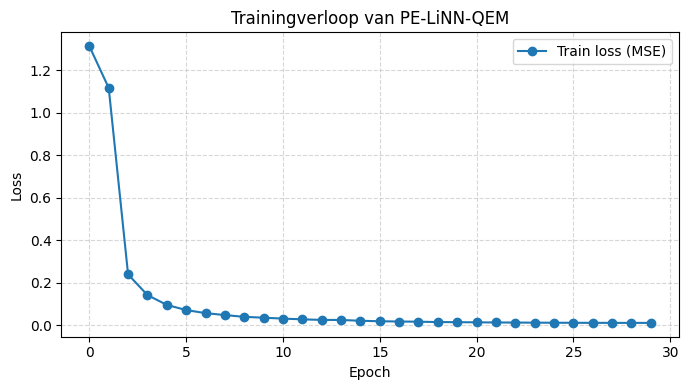

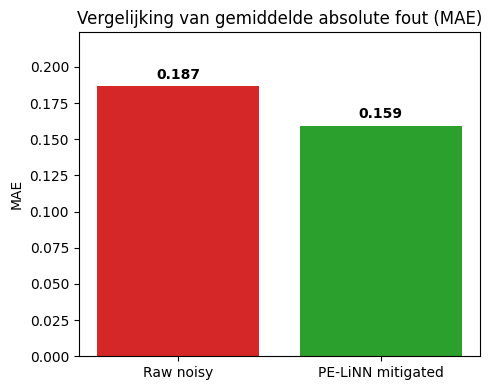

In [19]:
import matplotlib.pyplot as plt

# --- Vul hier je eigen data in ---
epochs = list(range(30))
losses = loss_out

raw_mae = 0.1866
mitigated_mae = 0.1594

# --- Plot 1: training loss ---
plt.figure(figsize=(7,4))
plt.plot(epochs, losses, marker='o', label='Train loss (MSE)')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Trainingverloop van PE-LiNN-QEM")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

# --- Plot 2: MAE-vergelijking ---
plt.figure(figsize=(5,4))
bars = ['Raw noisy', 'PE-LiNN mitigated']
values = [raw_mae, mitigated_mae]
colors = ['tab:red', 'tab:green']

plt.bar(bars, values, color=colors)
plt.ylabel("MAE")
plt.title("Vergelijking van gemiddelde absolute fout (MAE)")
for i, v in enumerate(values):
    plt.text(i, v + 0.005, f"{v:.3f}", ha='center', fontweight='bold')
plt.ylim(0, max(values)*1.2)
plt.tight_layout()
plt.show()
